# Training an ANN to represent the gravity produced by a spherical harmonics model
In this notebook we explore the possibility to use ANNs to represent the generic shape and density of an irregular body represented by a spherical harmonics model. The error is defined on the gravitational acceleration.

To run this notebook (and the others) create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib jupyter
 conda activate geodesyann
 conda install -c pytorch pytorch
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
 conda install pyvista pyvistaqt
```

To use CUDA, you will need to run
```
 conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
```


In [1]:
# core stuff
import gravann
import numpy as np
import pickle as pk
import os

# pytorch
from torch import nn
import torch
# For debugging and development purposes this is now set to float64 ... change for speed on GPUs
torch.set_default_tensor_type(torch.DoubleTensor)

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Available devices  1
__pyTorch VERSION: 1.6.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


## 1 - Instantiating the network
The networks inputs are the cartesian coordinates of a point in the unit cube, encoded via some transformation

In [2]:
# Encoding choosen
encoding = gravann.directional_encoding()

# Network initialization scheme (note that if xavier uniform is used all outputs will start at, roughly 0.5)
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.uniform_(m.bias.data, -0.0, 0.0)

# Network architecture. Note that the dimensionality of the first linear layer must match the output
# of the encoding chosen
n_neurons = 100
model = nn.Sequential(
          nn.Linear(encoding.dim,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,1),
          nn.Sigmoid(),
        )


# Applying our weight initialization
_  = model.apply(weights_init)

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []

# .. and we init some loss trend indicators
from collections import deque
weighted_average = deque([], maxlen=20)
running_loss = 1.

In [3]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
#model.load_state_dict(torch.load("models/" + name + "_" + encoding.name + "_ACC.mdl"))

## Visualizing an asteroid represented by the network
The network output is the density in the unit cube. It is, essentially, a three dimensional function and as such it is difficult to plot. 

### Approach 1: plotting a grid of points colored with the rho value

<IPython.core.display.Javascript object>


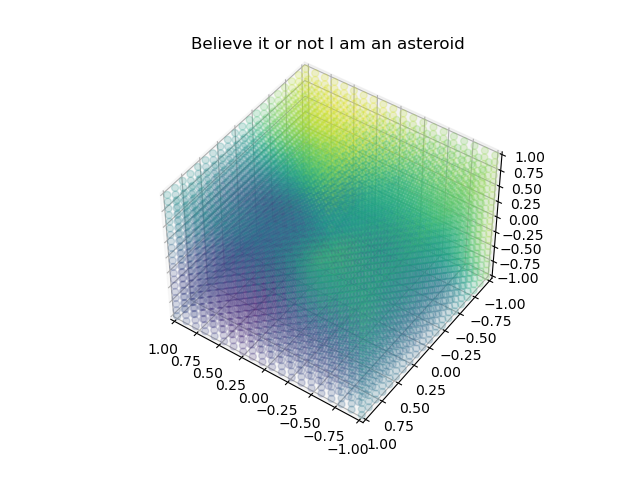

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [4]:
gravann.plot_model_grid(model, encoding, views_2d=False)
plt.title("Believe it or not I am an asteroid")

# Training The ANN to match the ground truth potential

Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [5]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Here we set some hyperparameters
N_mc_points = 200000
batch_size = 1000

# Here we set the loss
loss_fn = gravann.mse_loss

# Here we set the choosen Integration method
mc_method = gravann.ACC_ld
#mc_method = gravann.U_trap_opt

# Here we set the method to sample the target points
targets_point_sampler = gravann.get_target_point_sampler(batch_size, method="cubical", scale_bounds = [1.0, 1.1])

# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.5, patience = 5000, min_lr = 5e-6,verbose=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,nesterov=True)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.5, step_size_up=250, mode="exp_range", gamma = .997)

In [ ]:
# This cell can be stopped and started again without loosing memory of the training nor its indicators
import pykep
r, mu, c, s, n, m = pykep.util.load_gravity_model('spherical_harmonics/eros16.txt')

# The main training loop
for i in range(10000):
    targets = targets_point_sampler()
    # Labels are created from a spherical harmonics model
    acc = pykep.util.gravity_spherical_harmonic(np.array(targets.cpu()*r*1.5), r, 1000000000, c, s, 16, 16)
    labels = torch.tensor(acc, dtype=torch.float32)
    # Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
    predicted = mc_method(targets, model, encoding, N=N_mc_points)
    loss = loss_fn(predicted.view(-1), labels.view(-1))
    # Update the loss trend indicators
    running_loss = 0.9 * running_loss + 0.1 * loss.item()
    weighted_average.append(loss.item())
    # Update the logs
    running_loss_log.append(running_loss)
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((N_mc_points*batch_size) // 1000)
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.8f}\t  weighted_average={wa_out:.8f}\t  running_loss={running_loss:.8f}")
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()
    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

It=0	 loss=0.49781644	  weighted_average=0.49781644	  running_loss=0.94978164
It=25	 loss=0.41923127	  weighted_average=0.45527716	  running_loss=0.48343008
It=50	 loss=0.19413456	  weighted_average=0.30365234	  running_loss=0.29276149
It=75	 loss=0.02850718	  weighted_average=0.04515298	  running_loss=0.05732476
It=100	 loss=0.02042480	  weighted_average=0.02227968	  running_loss=0.02422580
It=125	 loss=0.02004951	  weighted_average=0.02024774	  running_loss=0.02055296
It=150	 loss=0.01918047	  weighted_average=0.01913649	  running_loss=0.01931949
It=175	 loss=0.01988743	  weighted_average=0.01899636	  running_loss=0.01897238
It=200	 loss=0.01782645	  weighted_average=0.01876398	  running_loss=0.01868365
It=225	 loss=0.01778762	  weighted_average=0.01802437	  running_loss=0.01798785
It=250	 loss=0.01784184	  weighted_average=0.01773056	  running_loss=0.01764865
It=275	 loss=0.01639760	  weighted_average=0.01718904	  running_loss=0.01708803
It=300	 loss=0.01496859	  weighted_average=0.

It=2550	 loss=0.00000566	  weighted_average=0.00000723	  running_loss=0.00000725
It=2575	 loss=0.00000641	  weighted_average=0.00000819	  running_loss=0.00000762
It=2600	 loss=0.00000941	  weighted_average=0.00002111	  running_loss=0.00001700
It=2625	 loss=0.00000752	  weighted_average=0.00000842	  running_loss=0.00000875
It=2650	 loss=0.00000768	  weighted_average=0.00000793	  running_loss=0.00000764
It=2675	 loss=0.00001039	  weighted_average=0.00000881	  running_loss=0.00000948
It=2700	 loss=0.00000788	  weighted_average=0.00000767	  running_loss=0.00000729
It=2725	 loss=0.00000650	  weighted_average=0.00000693	  running_loss=0.00000686
It=2750	 loss=0.00000570	  weighted_average=0.00000767	  running_loss=0.00000744
It=2775	 loss=0.00000673	  weighted_average=0.00000750	  running_loss=0.00000670
It=2800	 loss=0.00000582	  weighted_average=0.00000804	  running_loss=0.00000744
It=2825	 loss=0.00000700	  weighted_average=0.00000710	  running_loss=0.00000708
It=2850	 loss=0.00000690	  w

In [ ]:
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=50000, alpha=0.1, s=50)

In [ ]:
# Plot the loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa, loss_log)
plt.semilogy(abscissa, running_loss_log)
plt.semilogy(abscissa, weighted_average_log)
plt.xlabel("Thousands of model evaluations")
plt.ylabel("Loss")
plt.legend(["Loss","Running Loss","Weighted Average Loss"])

#### Saving the model

In [ ]:
# Uncomment to save to models/cluster_xxxx
#torch.save(model.state_dict(), "models/" + name + "_" + encoding.name + "_ACC.mdl")